In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import gsw
from gsw import conversions

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

In [3]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']
struct_axis = data['ax']
struct_slope = data['cs']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype
dtype_axis = struct_axis.dtype
dtype_slope = struct_slope.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}
data_axis = {n: struct_axis[n][0, 0] for n in dtype_axis.names}
data_slope = {n: struct_slope[n][0, 0] for n in dtype_slope.names}

obs_lat_s = data_south['latx'][0,:]
obs_lon_s = data_south['lonx'][0,:]
obs_z_s = data_south['z'][:, 0]
obs_s_s = data_south['sal'][:]


obs_lat_n = data_north['latx'][0,:]
obs_lon_n = data_north['lonx'][0,:]
obs_z_n = data_north['z'][:, 0]
obs_s_n = data_north['sal'][:]

obs_lat_p = data_slope['latx'][0,:]
obs_lon_p = data_slope['lonx'][0,:]
obs_z_p = data_slope['z'][:, 0]
obs_s_p = data_slope['sal'][:]

In [4]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    files = general_functions.get_files(dirname, fname, 'grid_T')        
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(files) as ds:
        vel0 = ds.variables['vosaline'][time_s:time_f,:,y,x]
        depth = ds.variables['deptht'][:]
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        mask0 = dsM.variables['tmask'][0,:,y,x]

    mask = np.tile(mask0, (vel0.shape[0], 1, 1, 1))

    vel = np.ma.array(vel0, mask=1 - mask)
    
    return vel, mask, depth, nav_lon, nav_lat

In [5]:
def reduce_list(any_list, number_of_values_to_combine):
    ret_list = []
    for i in range(len(any_list)//number_of_values_to_combine):
        new_value = 0
        for j in range(number_of_values_to_combine):
            new_value += any_list[i*number_of_values_to_combine + j]
        ret_list.append(new_value/number_of_values_to_combine)
    return ret_list

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_baseAW/'
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
time_s = 24
time_f = time_s+48

vosaline, tmask, deptht, nav_lon, nav_lat = get_vels(dirname, fname, meshmaskname, time_s, time_f)
vosaline_daily = np.mean(vosaline, axis=0)
tmask_daily = np.mean(tmask, axis=0)

f_s = interpolate.interp1d(deptht, vosaline_daily, axis=0, fill_value='extrapolate')
f_m = interpolate.interp1d(deptht, tmask_daily, axis=0, fill_value='extrapolate')

mod_s = f_s(obs_z_s)
mod_mask = f_m(obs_z_s)

27.40757351829892 31.066597202845983
28.54774892897833 32.203963143484934
30.672330692836216 32.97671450660342
31.42904964628674 33.15799734933036
31.929109773181732 33.30791404360817
32.25844239734468 33.41745438348679
32.63205402919224 33.530971926734566
32.89185296921503 33.86325091407413
33.07715403238932 34.19369227091472
33.298708852132165 34.50094375610352
33.55379137311663 34.69013116019113
33.85300064086914 34.79883637201219
34.16600886753627 34.87370870681036
34.3844617207845 34.92252731323242
34.538101159958615 34.949460928780695
34.650131516229536 34.96445512317476
34.735606820242744 34.973860350109284
34.80364023844401 34.97944615681966
34.85456041608538 34.98521957397461
34.8919308980306 34.99208123343332
34.918460482642764 34.99949682326544
34.93771769205729 35.00427594866071
34.953515588669546 35.00591953822545
34.96600984845843 35.00763680594308


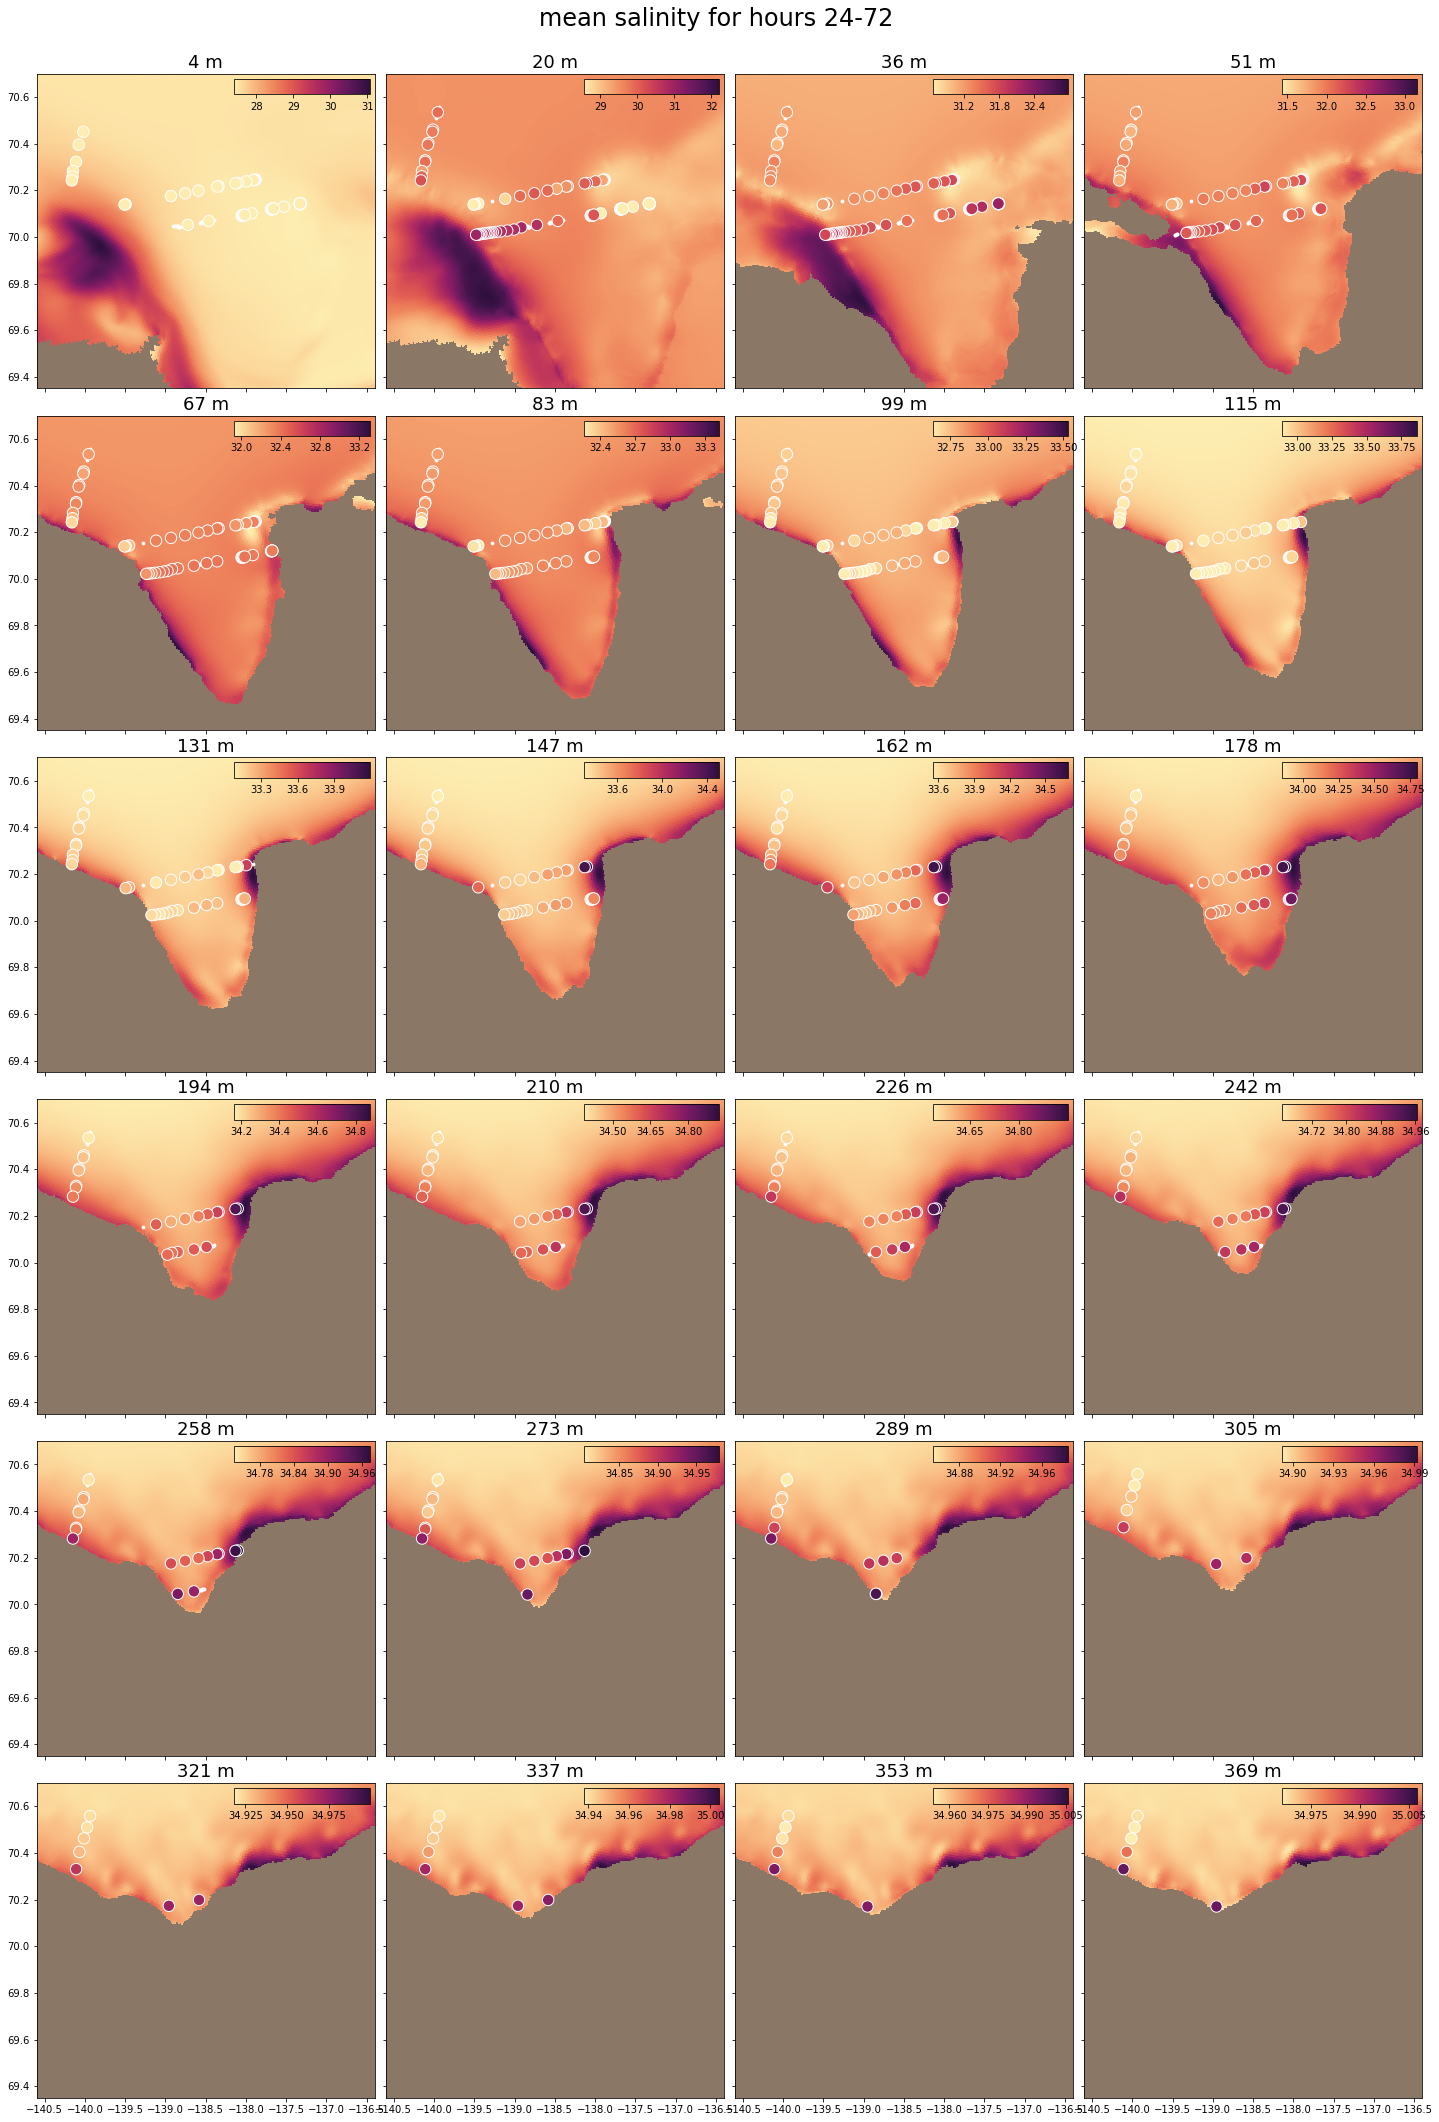

In [9]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), sharex=True, sharey=True)
n_depths = np.linspace(deptht.min(), len(obs_z_s)-1, 24).astype(int)
for ax, n in zip(axes.flatten(), n_depths):
    cmap = cmo.cm.matter
    cmap.set_bad('#8b7765')
    
    plot_mod_s = np.ma.array(mod_s[n, :, :], mask=1 - mod_mask[n, :, :])
    vmin, vmax = plot_mod_s.min(), plot_mod_s.max()
    print(vmin, vmax)
    
    ax.pcolormesh(nav_lon, nav_lat, plot_mod_s, vmin=vmin, vmax=vmax, cmap=cmap)
    
    obs_lon_list = [obs_lon_n, obs_lon_s, obs_lon_p]
    obs_lat_list = [obs_lat_n, obs_lat_s, obs_lat_p]
    obs_s_list   = [  obs_s_n,   obs_s_s,   obs_s_p]
    zos = [4, 3, 2]
    
    for obs_lon, obs_lat, obs_s0, zo in zip(obs_lon_list, obs_lat_list, obs_s_list, zos):
        
        p=10
        obs_s = conversions.SA_from_SP(obs_s0[n, :], p, obs_lon, obs_lat)
        
        if zo==4 and n<=289:
            e=2
        elif zo==3 and n<=51:
            e=10
        elif zo==3 and 51<n<=273:
            e=6
        elif zo==2 and n<=289:
            e=2
        else:
            e=1
            
        obs_lon_plot = reduce_list(obs_lon,e)
        obs_lat_plot = reduce_list(obs_lat,e)
        obs_s_plot = reduce_list(obs_s,e)
        
        p=ax.scatter(obs_lon_plot[::-1], obs_lat_plot[::-1], c=obs_s_plot[::-1], 
                     s=130, edgecolors='w', cmap=cmap, vmin=vmin, vmax=vmax, alpha=1, zorder=zo)
        
        if zo==3:
            ee = 25
            p=ax.scatter(obs_lon[-ee:], obs_lat[-ee:], c=obs_s[-ee:], 
                         s=140, edgecolors='w', cmap=cmap, vmin=vmin, vmax=vmax, alpha=1, zorder=zo)
        
        for i in range(len(obs_lon)):
            if np.isnan(obs_s[i]) == False:
                ax.scatter(obs_lon[i], obs_lat[i], c='w', s=8, zorder=1)
            else:
                pass

        
    ax.set_title(str(np.round(obs_z_s[n],1))+' m', fontsize=18)
    ax.set_xlim([-140.6, -136.4])
    ax.set_ylim([69.35, 70.7])
    w=1/math.cos(math.radians(69.8))
    ax.set_aspect(w)

    axins = inset_axes(ax,
                    width="40%",  # width = 10% of parent_bbox width
                    height="5%",  # height : 50%
                    loc=1)
    axins.xaxis.set_ticks_position("bottom")
    cb = fig.colorbar(p, cax=axins, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    
fig.tight_layout(w_pad=0.4, h_pad=0.8)
plt.subplots_adjust(top=0.95)
fig.suptitle('mean salinity for hours ' + str(time_s) + '-'+ str(time_f), fontsize=24)
fig.patch.set_facecolor('white') 
fig.savefig('./salinity_comparison_interp.png', dpi=150, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())